## 4-1 & 5-1 Research Hypothesis 1

In [1]:
# Import the necessary libraries
import os 
import pandas as pd
import numpy as np
from timezonefinder import TimezoneFinder
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Load the datasets

In [2]:
# Define a list of states for which datasets will be loaded
state_list = ['Texas', 'Iowa', 'Nevada', 'Seattle']

# Define the base folder path where the datasets are located
base_folder_path = './Data/'

# Create an empty dictionary to store DataFrames
dfs = {}

# Loop through each state and load the corresponding dataset
for state in state_list:
    # Construct the file path for the dataset of the current state
    file_path = os.path.join(base_folder_path, f'{state}_0_18.csv')
    
    # Define a key for the DataFrame in the dictionary
    df_key = f'df_{state}'
    
    # Load the dataset into a Pandas DataFrame and store it in the dictionary
    dfs[df_key] = pd.read_csv(file_path)

# List the keys (DataFrame names) stored in the 'dfs' dictionary
loaded_datasets = list(dfs)
print(loaded_datasets)

['df_Texas', 'df_Iowa', 'df_Nevada', 'df_Seattle']


### Convert the datetime from UTC to LST (Local Standard Time)

In [3]:
# Define a dictionary that maps state names to their corresponding latitude and longitude coordinates
locations = {
    'Texas': (30.6095651015, -96.3402969602),
    'Nevada': (36.089758655, -115.1833049303),
    'Iowa': (42.0135891695, -93.6356966723),
    'Seattle': (48.6108182606, -123.1479221551)
}

# Initialize a TimezoneFinder instance to determine timezones based on coordinates
tf = TimezoneFinder()

# Assuming 'dfs' is your dictionary of DataFrames
for df_key in dfs:
    # Extract the state name from the DataFrame key
    state = df_key.split('_')[1]

    # Retrieve the latitude and longitude for the state from the 'locations' dictionary
    latitude, longitude = locations[state]

    # Find the timezone for the given latitude and longitude using the TimezoneFinder
    local_timezone = tf.timezone_at(lat=latitude, lng=longitude)

    # Convert the 'datetime' column in the DataFrame to datetime objects
    dfs[df_key]['datetime'] = pd.to_datetime(dfs[df_key]['datetime'])

    # Set the timezone of the 'datetime' column to UTC
    dfs[df_key]['datetime'] = dfs[df_key]['datetime'].dt.tz_localize('UTC')

    # Convert the 'datetime' column to the local timezone
    dfs[df_key]['datetime'] = dfs[df_key]['datetime'].dt.tz_convert(local_timezone)
    dfs[df_key]['datetime'] = dfs[df_key]['datetime'].dt.tz_localize(None)

In [4]:
dfs['df_Texas'].head()

,datetime,ta,GHI,rh,va,cloud,forecast,WBGT
0,2023-05-31 19:00:00,30.78134,199.9,46.2,2.506479,0.0,0,25.638261
1,2023-05-31 20:00:00,29.45638,23.1,49.9,1.875911,4.0,0,23.810995
2,2023-05-31 20:00:00,28.69420,28.2,52.6,3.799318,0.0,1,23.394587
3,2023-05-31 21:00:00,27.83575,0.0,55.4,3.317077,0.0,0,22.780433
4,2023-05-31 21:00:00,26.84966,0.0,65.8,4.094820,0.0,1,23.055983


### Extract only hour of 12 and 15 and forecast of 0 and 3

In [5]:
# Iterate through each DataFrame in the dictionary
for df_key in dfs:
    # Convert the 'datetime' column to pandas datetime format
    dfs[df_key]['datetime'] = pd.to_datetime(dfs[df_key]['datetime'])

    # Define the desired times for filtering
    desired_times = ['12:00:00', '15:00:00']

    # Filter the DataFrame for hours between 12:00:00 and 15:00:00
    dfs[df_key] = dfs[df_key][dfs[df_key]['datetime'].dt.strftime('%H:%M:%S').isin(desired_times)]

    # Define the desired forecast values for filtering
    desired_forecasts = [0, 3]

    # Extract rows where forecast is either 0 or 3
    dfs[df_key] = dfs[df_key][dfs[df_key]['forecast'].isin(desired_forecasts)]

    # Reset the index of the filtered DataFrame
    dfs[df_key] = dfs[df_key].reset_index(drop=True)

### Calculates differences based on the observed values (when forecast == 0)

In [6]:
# Iterate through each DataFrame in the dictionary
for df_key in dfs:
    # Convert the 'datetime' column to pandas datetime format
    dfs[df_key]['datetime'] = pd.to_datetime(dfs[df_key]['datetime'])

    # Define the desired times for filtering
    desired_times = ['12:00:00', '15:00:00']

    # Filter the DataFrame for hours between 12:00:00 and 15:00:00
    dfs[df_key] = dfs[df_key][dfs[df_key]['datetime'].dt.strftime('%H:%M:%S').isin(desired_times)]

    # Define the desired forecast values for filtering
    desired_forecasts = [0, 3]

    # Extract rows where forecast is either 0 or 3
    dfs[df_key] = dfs[df_key][dfs[df_key]['forecast'].isin(desired_forecasts)]

    # Reset the index of the filtered DataFrame
    dfs[df_key] = dfs[df_key].reset_index(drop=True)


# Iterate through each DataFrame in the dictionary
for df_key in dfs:
    # Convert the 'datetime' column to pandas datetime format
    dfs[df_key]['datetime'] = pd.to_datetime(dfs[df_key]['datetime'])

    # Filter to get the rows where forecast == 0
    reference_df = dfs[df_key][dfs[df_key]['forecast'] == 0]

    # Merge the original DataFrame with the reference DataFrame
    merged_df = dfs[df_key].merge(reference_df[['datetime', 'ta', 'GHI', 'rh', 'va', 'cloud', 'WBGT']], on='datetime', suffixes=('', '_ref'))

    # Calculate the forecast error for each column
    merged_df['ta_error'] = merged_df['ta'] - merged_df['ta_ref']
    merged_df['GHI_error'] = merged_df['GHI'] - merged_df['GHI_ref']
    merged_df['rh_error'] = merged_df['rh'] - merged_df['rh_ref']
    merged_df['va_error'] = merged_df['va'] - merged_df['va_ref']
    merged_df['cloud_error'] = merged_df['cloud'] - merged_df['cloud_ref']
    merged_df['WBGT_error'] = merged_df['WBGT'] - merged_df['WBGT_ref']

    # Save the merged DataFrame back into the dictionary
    dfs[df_key] = merged_df

### Combined as one dataframe

In [7]:
#Rename each columns
df_T = dfs['df_Texas'][['datetime', 'GHI_error', 'cloud_error', 'forecast']]
df_T = df_T.rename(columns={'GHI_error': 'GHI_error_Texas', 'cloud_error': 'cloud_error_Texas'})

df_I = dfs['df_Iowa'][['datetime', 'GHI_error', 'cloud_error', 'forecast']]
df_I = df_I.rename(columns={'GHI_error': 'GHI_error_Iowa', 'cloud_error': 'cloud_error_Iowa'})

df_N = dfs['df_Nevada'][['datetime', 'GHI_error', 'cloud_error', 'forecast']]
df_N = df_N.rename(columns={'GHI_error': 'GHI_error_Nevada', 'cloud_error': 'cloud_error_Nevada'})

df_S = dfs['df_Seattle'][['datetime', 'GHI_error', 'cloud_error', 'forecast']]
df_S = df_S.rename(columns={'GHI_error': 'GHI_error_Seattle', 'cloud_error': 'cloud_error_Seattle'})

# Custom suffixes can be provided to avoid column name conflicts
custom_suffixes = ('_dfT', '_dfI')  # You can choose appropriate suffixes

# Merging df_T and df_I with custom suffixes, on both 'datetime' and 'forecast'
combined_df = pd.merge(df_T, df_I, on=['datetime', 'forecast'], how='inner', suffixes=custom_suffixes)

# Merging with df_N and df_S
# Note: You may need to adjust suffixes again if there are still conflicts
combined_df = pd.merge(combined_df, df_N, on=['datetime', 'forecast'], how='inner')
combined_df = pd.merge(combined_df, df_S, on=['datetime', 'forecast'], how='inner')

combined_df.head()

,datetime,GHI_error_Texas,cloud_error_Texas,forecast,GHI_error_Iowa,cloud_error_Iowa,GHI_error_Nevada,cloud_error_Nevada,GHI_error_Seattle,cloud_error_Seattle
0,2023-06-01 12:00:00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-06-01 12:00:00,10.0,-19.0,3,78.0,4.0,13.0,0.0,1.0,-18.0
2,2023-06-01 15:00:00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-06-01 15:00:00,13.0,-12.0,3,-472.0,21.0,604.0,14.0,4.0,0.0
4,2023-06-02 12:00:00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#only 3-hour forecast
for df_key in dfs:
    dfs[df_key] = dfs[df_key].loc[dfs[df_key]['forecast'] == 3]

    # Reset the index
    dfs[df_key] = dfs[df_key].reset_index(drop=True)

# only for errors
for df_key in dfs:
    error_columns = dfs[df_key].filter(like='_error').columns
    dfs[df_key] = dfs[df_key][error_columns]

In [9]:
dfs['df_Texas'].head()

,ta_error,GHI_error,rh_error,va_error,cloud_error,WBGT_error
0,0.10763,10.0,-5.0,1.510041,-19.0,-0.610875
1,-0.06998,13.0,-1.6,0.646930,-12.0,-0.318283
2,0.10623,3.0,-7.5,0.374193,-21.0,-0.881532
3,0.07323,-101.0,-7.3,0.956350,3.0,-0.991742
4,0.82907,-1.0,-7.8,2.425207,0.0,-0.434563


### Association of variables with GHI_error

In [10]:
# Pearson Correlation

# Make a copy of the combined dataframe for analysis
df = combined_df.copy()

# Define a list of states to analyze
states = ['Texas', 'Iowa', 'Nevada', 'Seattle']

# Calculate the Pearson Correlation between GHI (Global Horizontal Irradiance) error 
# and cloud error for each state in the list
for state in states:
    ghi_error = f'GHI_error_{state}'  # Column name for GHI error specific to the state
    cloud_error = f'cloud_error_{state}'  # Column name for cloud error specific to the state
    
    # Compute the Pearson Correlation coefficient and p-value for the two variables
    correlation, p_value = stats.pearsonr(df[ghi_error], df[cloud_error])
    
    # Print the Pearson Correlation and p-value for the current state
    print(f'Pearson Correlation for {state}: {correlation}, P-value: {p_value}')

Pearson Correlation for Texas: -0.22372873217901015, P-value: 1.643449621883602e-05
Pearson Correlation for Iowa: -0.4677677149674231, P-value: 3.4466073881519424e-21
Pearson Correlation for Nevada: -0.35882134905150004, P-value: 1.6798591623445183e-12
Pearson Correlation for Seattle: -0.393517205309856, P-value: 6.244754684374939e-15


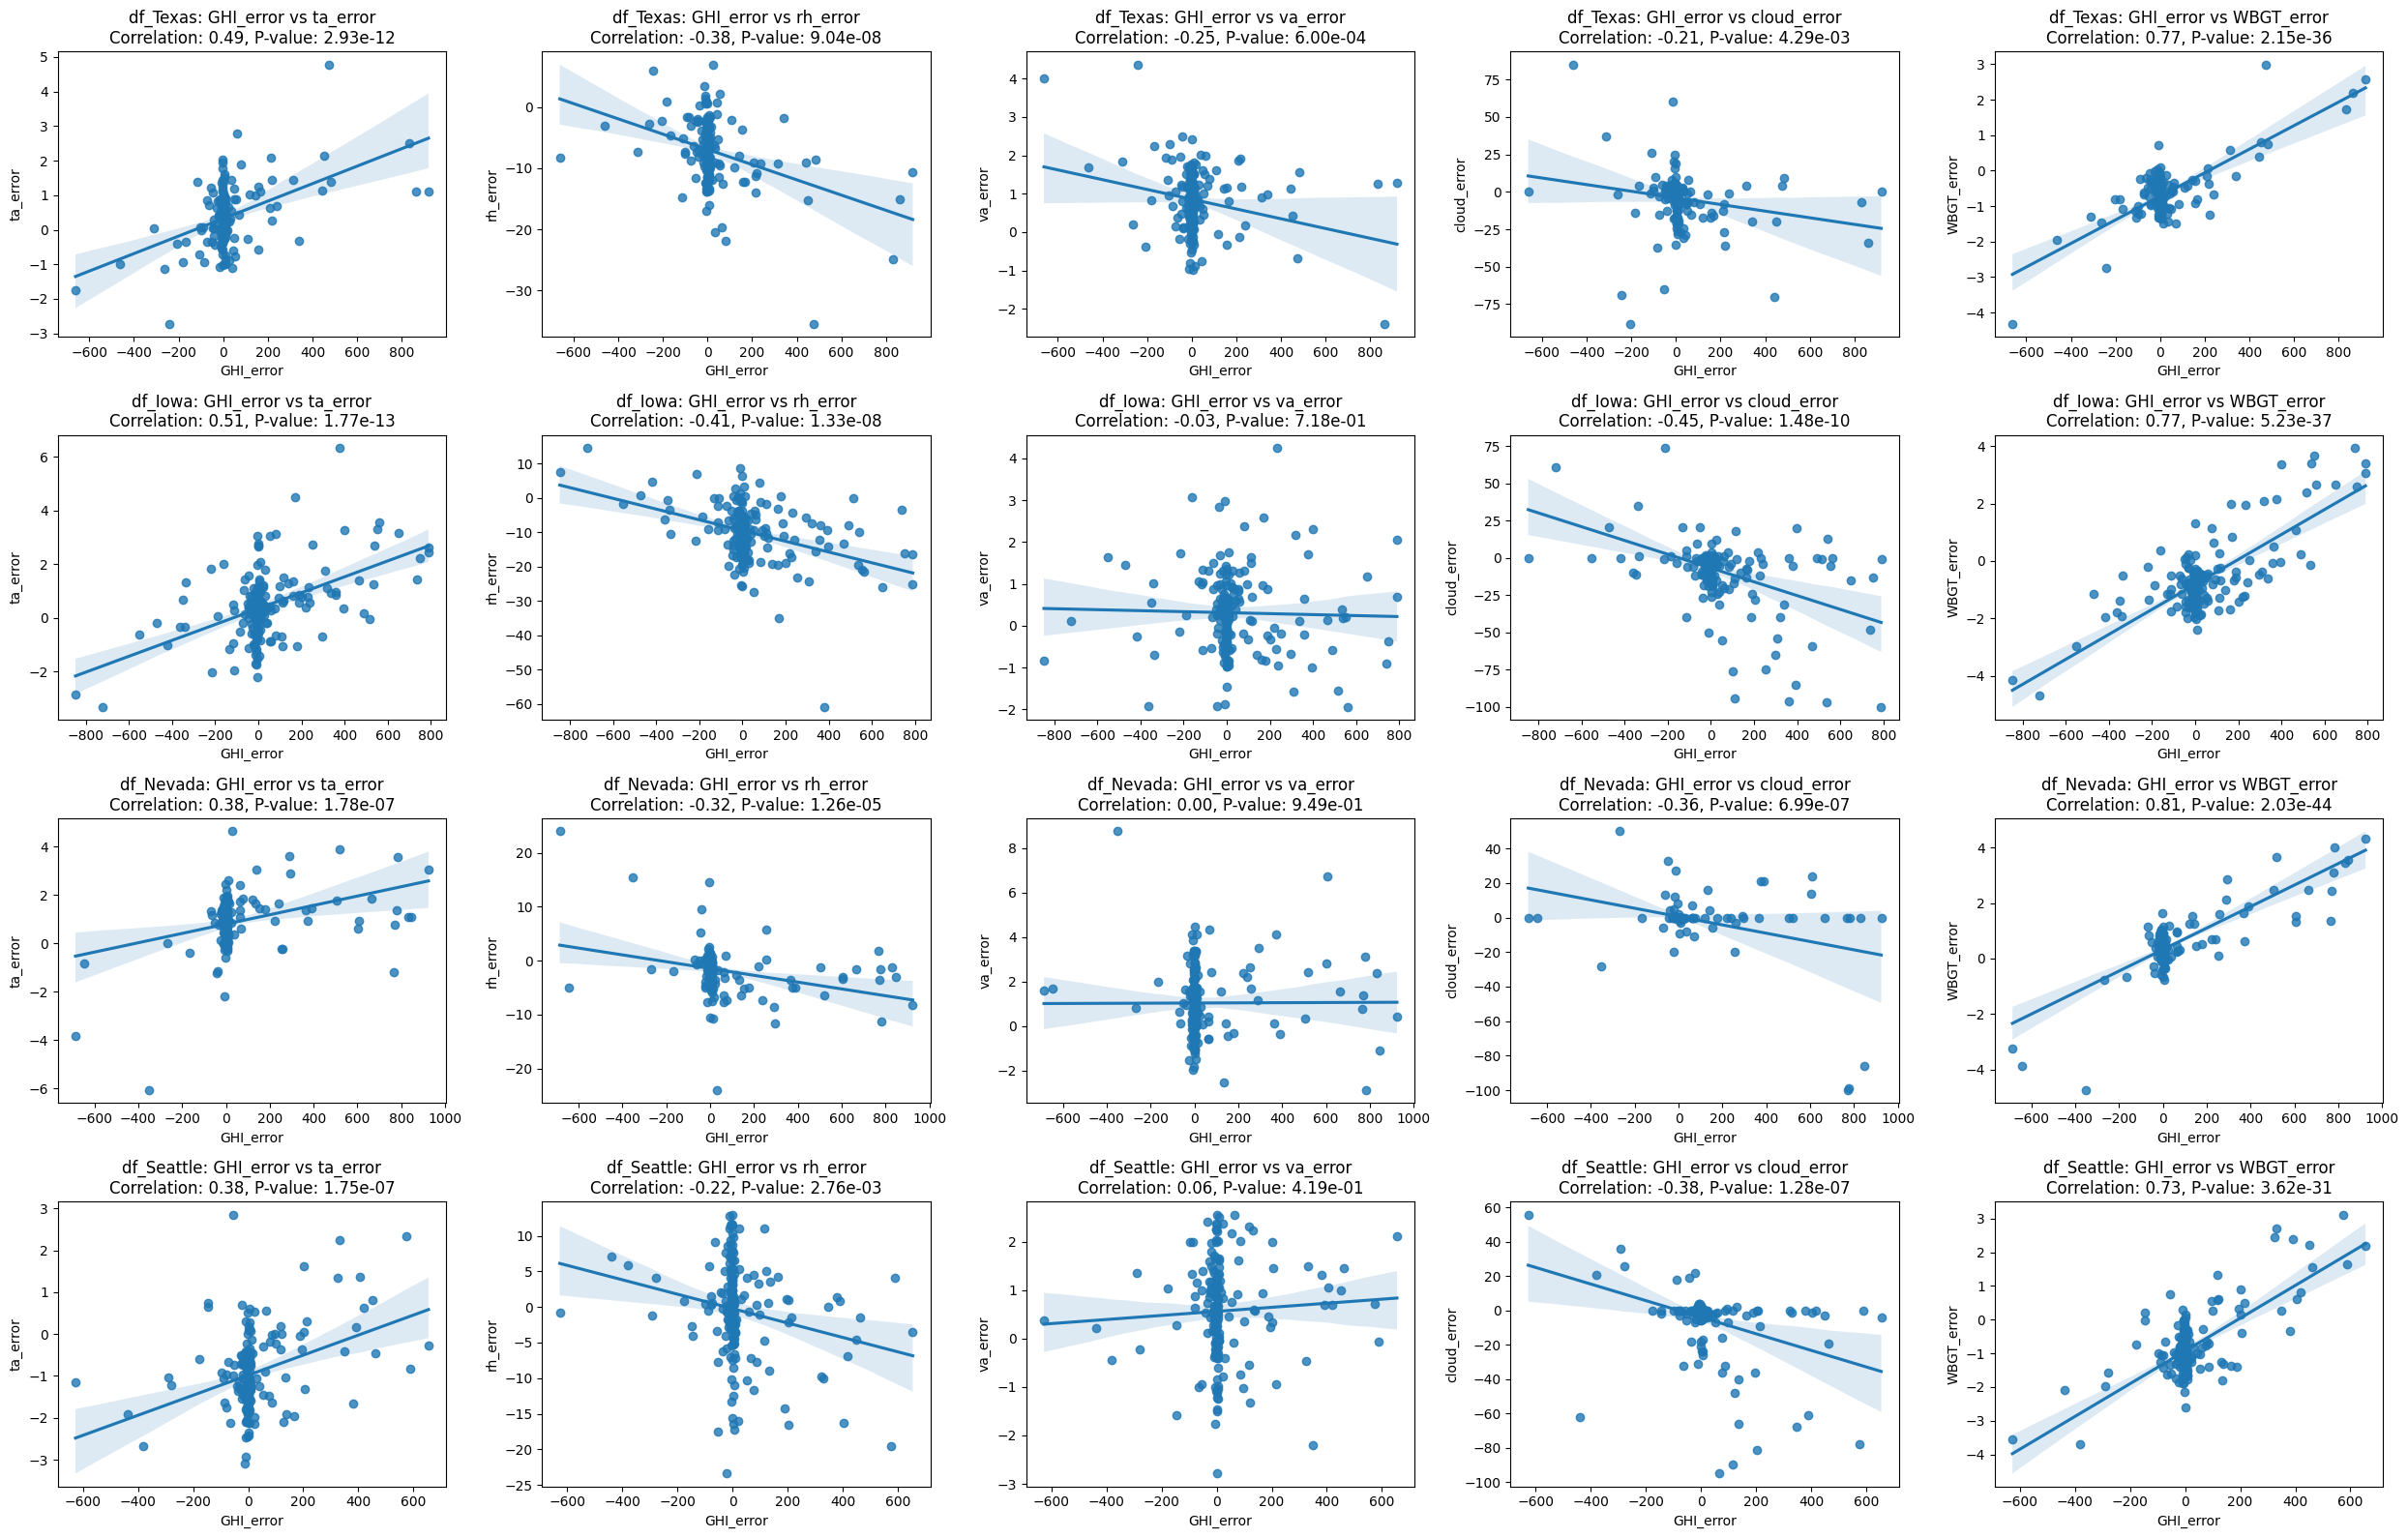

In [14]:
# Get the total number of DataFrames in the 'dfs' dictionary
num_rows = len(dfs)

# Calculate the maximum number of columns among the DataFrames, excluding 'GHI_error'
num_cols = max(len(df.columns) - 1 for df in dfs.values())  # Subtract 1 to exclude 'GHI_error'

# Create a figure with subplots based on the number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))  # Adjust the figure size as needed

# Iterate over each DataFrame and each column in the DataFrames
for i, (df_key, df) in enumerate(dfs.items()):
    if 'GHI_error' in df.columns:
        # Iterate over columns in the DataFrame excluding 'GHI_error'
        for j, column in enumerate([col for col in df.columns if col != 'GHI_error']):
            # Calculate the Pearson correlation coefficient and p-value
            correlation, p_value = stats.pearsonr(df['GHI_error'], df[column])

            # Create a scatter plot with a regression line in the appropriate subplot
            sns.regplot(x='GHI_error', y=column, data=df, ax=axes[i, j])

            # Set the subplot title with the correlation value and p-value
            axes[i, j].set_title(f'{df_key}: GHI_error vs {column}\nCorrelation: {correlation:.2f}, P-value: {p_value:.2e}')
    else:
        # Print a message if 'GHI_error' is not found in the DataFrame
        print(f"'GHI_error' not found in {df_key}")

# Adjust the layout of subplots for better visualization
plt.tight_layout()

# Save the resulting figure as an image with high DPI, transparency, and tight bounding box
plt.savefig('./Result/RH1_Correlation.png', dpi=500, transparent=True, bbox_inches='tight')

# Display the figure
plt.show()